In [1]:
import numpy as np
import pandas as pd

In [2]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/proj/data/train.csv', sep='\t')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/proj/data/test.csv', sep = '\t')
dev_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/proj/data/dev.csv', sep = '\t')

In [3]:
train_feature_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/proj/data/train_feature_df2.csv', sep='\t')
test_feature_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/proj/data/test_feature_df2.csv', sep = '\t')
dev_feature_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/proj/data/dev_feature_df2.csv', sep = '\t')
train_feature_df

,Unnamed: 0,user_id,label,last_day,rounds,num_days,max_level,succ_max_level,total_duration,succ_total_duration,mean_reststep,succ_mean_reststep,all_help,succ_all_help,passrate,time_ratio,suc_time_ratio,1sep_time,1num_succ,1last_level,1last_trytimes,1max_retrytimes,1num_levels,1passrate_ratio,1retrytimes_ratio,1num_rounds,1total_duration,1num_help,1win_duration_ratio,2sep_time,2num_succ,2last_level,2last_trytimes,2max_retrytimes,2num_levels,2passrate_ratio,2retrytimes_ratio,2num_rounds,2total_duration,2num_help,2win_duration_ratio,2last_time,3sep_time,3num_succ,3last_level,3last_trytimes,3max_retrytimes,3num_levels,3passrate_ratio,3retrytimes_ratio,3num_rounds,3total_duration,3num_help,3win_duration_ratio,3last_time,4sep_time,4num_succ,4last_level,4last_trytimes,4max_retrytimes,4num_levels,4passrate_ratio,4retrytimes_ratio,4num_rounds,4total_duration,4num_help,4win_duration_ratio,4last_time
0,0,2774,0,4.0,215.0,4.0,134.0,133.0,25398.0,15005.0,0.189056,0.265700,18.0,14.0,0.632558,0.464307,1.023872,46713.0,59.0,116.0,1.0,3.0,56.0,1.004697,0.279470,73.0,8743.0,3.0,1.128784,55438.0,29.0,116.0,12.0,7.0,20.0,1.125680,0.810917,46.0,5330.0,3.0,0.942069,1.0,84474.0,35.0,123.0,1.0,10.0,37.0,1.126512,0.657605,65.0,7096.0,9.0,0.941808,1.0,49594.0,13.0,134.0,5.0,5.0,15.0,0.894427,2.095213,31.0,4229.0,3.0,0.930846,1.0
1,1,2775,0,4.0,111.0,3.0,116.0,116.0,18839.0,13942.0,0.258456,0.305587,14.0,13.0,0.738739,0.898179,1.623440,75462.0,46.0,45.0,1.0,3.0,45.0,1.023738,0.204502,55.0,6773.0,8.0,1.232778,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,4770.0,16.0,116.0,1.0,1.0,16.0,1.048408,0.300045,21.0,4276.0,3.0,1.642346,0.0,27625.0,20.0,81.0,5.0,5.0,20.0,1.024516,0.769187,35.0,7790.0,3.0,2.250542,1.0
2,2,2776,1,3.0,69.0,3.0,123.0,119.0,6119.0,3984.0,0.186543,0.292533,1.0,1.0,0.637681,0.469643,0.826228,64912.0,39.0,123.0,1.0,4.0,40.0,1.097110,0.248792,49.0,4300.0,1.0,0.837336,17985.0,3.0,68.0,9.0,9.0,4.0,0.768579,2.568146,13.0,1112.0,0.0,0.918683,1.0,49929.0,2.0,70.0,3.0,3.0,3.0,0.403156,1.762801,7.0,707.0,0.0,0.916467,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
3,3,2777,0,4.0,286.0,4.0,164.0,162.0,40808.0,18576.0,0.124245,0.245062,4.0,3.0,0.506993,0.444016,1.159537,71939.0,65.0,116.0,1.0,5.0,66.0,0.991583,0.518244,93.0,11203.0,0.0,1.064818,67628.0,51.0,141.0,1.0,4.0,55.0,0.896006,0.958794,96.0,14112.0,1.0,1.080538,1.0,29553.0,18.0,153.0,1.0,7.0,19.0,1.063837,1.864522,48.0,8663.0,1.0,1.631832,1.0,26299.0,11.0,164.0,12.0,12.0,14.0,0.738995,3.354036,49.0,6830.0,2.0,1.097669,1.0
4,4,2778,1,3.0,162.0,3.0,122.0,122.0,32045.0,17839.0,0.299450,0.324443,9.0,9.0,0.672840,0.845176,1.465325,77796.0,99.0,122.0,1.0,18.0,87.0,1.127967,0.507783,136.0,26400.0,9.0,1.445506,14430.0,4.0,122.0,2.0,8.0,3.0,0.803819,3.137302,13.0,2806.0,0.0,1.389755,1.0,3676.0,6.0,99.0,4.0,4.0,6.0,1.099679,1.367873,13.0,2839.0,0.0,1.868698,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8153,8153,10927,1,4.0,350.0,4.0,207.0,206.0,34697.0,14681.0,0.166471,0.329179,10.0,6.0,0.505714,0.251358,0.744950,14106.0,52.0,52.0,1.0,3.0,52.0,1.071706,0.158491,60.0,4278.0,0.0,0.761726,82318.0,99.0,179.0,1.0,8.0,101.0,1.136235,2.217590,199.0,19627.0,5.0,0.725830,1.0,63292.0,11.0,192.0,5.0,6.0,13.0,1.173134,1.851064,37.0,3485.0,2.0,0.718428,1.0,25660.0,15.0,207.0,7.0,9.0,16.0,1.267583,3.122715,54.0,7307.0,3.0,1.164982,1.0
8154,8154,10928,1,2.0,50.0,2.0,48.0,48.0,4073.0,4073.0,0.471203,0.471203,3.0,3.0,1.000000,0.603506,0.852636,3715.0,40.0,38.0,1.0,0.0,38.0,1.084387,0.000000,40.0,3096.0,3.0,0.851944,65752.0,10.0,48.0,1.0,0.0,10.0,1.249918,0.000000,10.0,977.0,0.0,0.905527,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0

# 去极值离散特征

In [13]:
feature_names = train_feature_df.columns[3:]
print(feature_names)

Index(['last_day', 'rounds', 'num_days', 'max_level', 'succ_max_level',
       'total_duration', 'succ_total_duration', 'mean_reststep',
       'succ_mean_reststep', 'all_help', 'succ_all_help', 'passrate',
       'time_ratio', 'suc_time_ratio', '1sep_time', '1num_succ', '1last_level',
       '1last_trytimes', '1max_retrytimes', '1num_levels', '1passrate_ratio',
       '1retrytimes_ratio', '1num_rounds', '1total_duration', '1num_help',
       '1win_duration_ratio', '2sep_time', '2num_succ', '2last_level',
       '2last_trytimes', '2max_retrytimes', '2num_levels', '2passrate_ratio',
       '2retrytimes_ratio', '2num_rounds', '2total_duration', '2num_help',
       '2win_duration_ratio', '2last_time', '3sep_time', '3num_succ',
       '3last_level', '3last_trytimes', '3max_retrytimes', '3num_levels',
       '3passrate_ratio', '3retrytimes_ratio', '3num_rounds',
       '3total_duration', '3num_help', '3win_duration_ratio', '3last_time',
       '4sep_time', '4num_succ', '4last_level', '4last

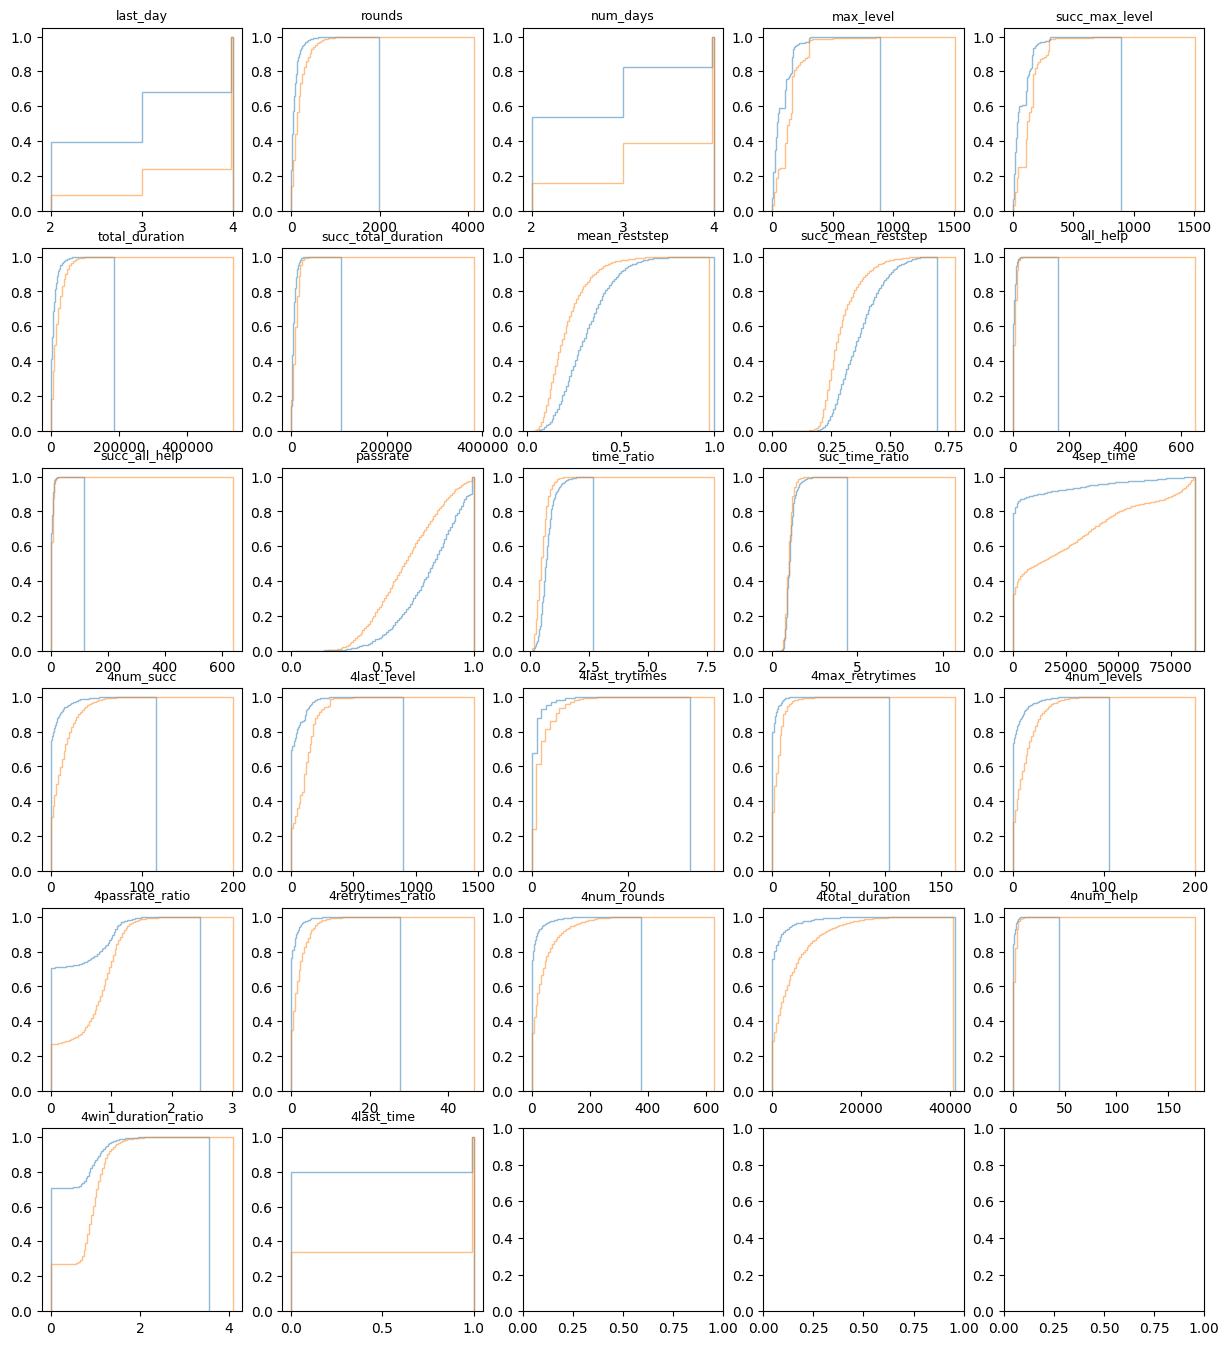

In [14]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(6, 5, figsize = (15, 17), dpi = 100)
ax = axes.flatten()

fea_index = list(range(3, 17)) + list(range(55, 68))

for i, c in enumerate(train_feature_df.columns[fea_index]):
 ax[i].hist(train_feature_df.loc[train_df['label'] == 1][c], bins = 100, alpha = 0.5, histtype='step', cumulative = True, density=True)
 ax[i].hist(train_feature_df.loc[train_df['label'] == 0][c], bins = 100, alpha = 0.5, histtype='step', cumulative = True, density=True)
 ax[i].set_title(c, fontsize = 9)

#plt.savefig("beforeDiscrete.png") #保存作的图
plt.show()

In [15]:
#离散化，返回离散后的df, 和bins
def discretedf(df, num, choice):
 discrete_df = df.copy() # 先复制一份数据
 discrete_df2 = df.copy() #再复制一份数据，使用另一种方式进行离散化

 bins1_dic = {}
 bins2_dic = {}

 for c in df.columns[3:]: # 遍历每一列特征，跳过标签列
  # if c == 'last_day' or c == 'num_dyas' or c == '2.0last_time' or c == '3.0last_time' or c == '4.0last_time':continue

  #离散方法1：去极值后按x值等区间划分
  win_l = df.loc[df['label'] == 1][c].tolist()
  lose_l = df.loc[df['label'] == 0][c].tolist()
  win_l.sort()
  lose_l.sort()
  lowerbound = win_l[int(0.02 * len(win_l))]
  upperbound = lose_l[int(0.98 * len(lose_l))]
  step = int((upperbound - lowerbound) * 1000 /num) #可调参数：分成几个区间
  bins1 = [ -np.inf] + [ i/1000 for i in list(range(int(lowerbound*1000), int(upperbound*1000), step))] + [upperbound, np.inf]
  bins1_dic[c] = bins1
  discrete_df[c] = pd.cut(discrete_df[c],bins1, labels = False)

  #离散方法2：等比划分
  listl = df[c].tolist()
  listl.sort()
  lower = listl[int(0.02 * len(listl))]
  upper = listl[int(0.98 * len(listl))]
  bins2 = [-np.inf, lower, upper, np.inf]
  for i in range(1,num):
    new = listl[int((i/num)*len(listl))]
    bins2.append(new)
  bins2 = set(bins2)
  bins2 = list(bins2)
  bins2.sort()
  bins2_dic[c] = bins2
  discrete_df2[c] = pd.cut(discrete_df2[c],bins2, labels = False)

 if choice == 1: return discrete_df, bins1_dic, bins2_dic
 if choice == 2: return discrete_df2, bins1_dic, bins2_dic

#apply 离散化，用于验证集和测试集
def applydiscretedf(df, bins):
  discrete_df = df.copy() # 先复制一份数据

  for c in df.columns[3:]: # 遍历每一列特征，跳过标签列
    if c == 'last_day' or c == 'num_dyas' or c == '2.0last_time' or c == '3.0last_time' or c == '4.0last_time':continue
    discrete_df[c] = pd.cut(discrete_df[c],bins[c], labels = False)
  
  return discrete_df



In [16]:
#等区间划分
discrete_train_df, bins1, bins2 = discretedf(train_feature_df, 10, 1)
discrete_train_df

,Unnamed: 0,user_id,label,last_day,rounds,num_days,max_level,succ_max_level,total_duration,succ_total_duration,mean_reststep,succ_mean_reststep,all_help,succ_all_help,passrate,time_ratio,suc_time_ratio,1sep_time,1num_succ,1last_level,1last_trytimes,1max_retrytimes,1num_levels,1passrate_ratio,1retrytimes_ratio,1num_rounds,1total_duration,1num_help,1win_duration_ratio,2sep_time,2num_succ,2last_level,2last_trytimes,2max_retrytimes,2num_levels,2passrate_ratio,2retrytimes_ratio,2num_rounds,2total_duration,2num_help,2win_duration_ratio,2last_time,3sep_time,3num_succ,3last_level,3last_trytimes,3max_retrytimes,3num_levels,3passrate_ratio,3retrytimes_ratio,3num_rounds,3total_duration,3num_help,3win_duration_ratio,3last_time,4sep_time,4num_succ,4last_level,4last_trytimes,4max_retrytimes,4num_levels,4passrate_ratio,4retrytimes_ratio,4num_rounds,4total_duration,4num_help,4win_duration_ratio,4last_time
0,0,2774,0,10,3,10,5,5,4,6,3,2,7,8,5,3,4,6,5,7,0,3,5,9,2,4,4,3,6,7,3,4,11,4,2,9,2,2,2,3,6,10,10,6,4,1,5,6,8,1,3,4,10,6,10,6,3,5,6,3,3,7,3,2,3,4,6,10
1,1,2775,0,10,2,5,4,4,3,6,4,3,6,7,6,7,11,10,4,3,0,3,4,9,2,3,4,8,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,4,1,1,3,8,1,1,2,4,10,0,4,4,3,6,3,4,8,1,2,4,4,12,10
2,2,2776,1,5,1,5,4,4,1,2,3,3,1,1,5,3,2,9,3,7,0,4,4,10,2,3,2,1,3,3,1,3,11,5,1,6,5,1,1,0,6,10,6,1,3,3,2,1,3,3,1,1,0,6,10,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,2777,0,10,4,10,6,6,6,7,1,1,2,2,3,3,6,10,5,7,0,4,6,9,3,5,6,0,5,8,5,5,2,2,6,7,2,4,6,1,7,10,4,3,5,1,4,4,8,3,3,4,2,10,10,4,3,6,11,6,3,6,4,3,4,3,7,10
4,4,2778,1,5,3,5,4,4,5,7,5,4,4,5,5,7,9,10,8,7,0,11,7,10,3,7,11,9,8,2,1,4,3,4,1,6,7,1,2,0,9,10,1,1,4,4,2,1,8,2,1,2,0,12,10,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8153,8153,10927,1,10,5,10,7,7,5,6,2,4,4,4,3,1,1,2,4,3,0,3,5,9,1,3,2,0,3,10,10,6,2,4,10,9,5,8,8,5,5,10,8,2,7,5,3,3,9,3,2,2,3,5,10,3,3,7,8,4,3,9,4,3,4,4,7,10
8154,8154,10928,1,0,1,0,2,2,1,2,9,9,2,2,11,4,3,1,3,3,0,0,3,10,0,2,2,3,3,8,1,2,2,0,1,10,0,1,1,0,6,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8155,8155,10929,0,10,4,5,4,4,4,5,1,2,6,5,2,3,4,0,0,0,0,0,0,0,0,0,0,0,0,10,7,4,2,3,7,7,2,5,5,2,6,0,10,5,4,1,5,6,6,3,4,5,9,6,10,9,3,4,5,3,3,6,3,2,3,5,6,10
8156,8156,10930,1,5,1,0,2,2,1,3,7,7,3,4,10,12,11,0,0,0,0,0,0,0,0,0,0,0,0,1,3,1,2,0,3,8,0,1,1,2,8,0,3,2,2,1,1,2,8,1,1,2,5,12,10,0,0,0,0,0,0,0,0,0,0,0,0,0


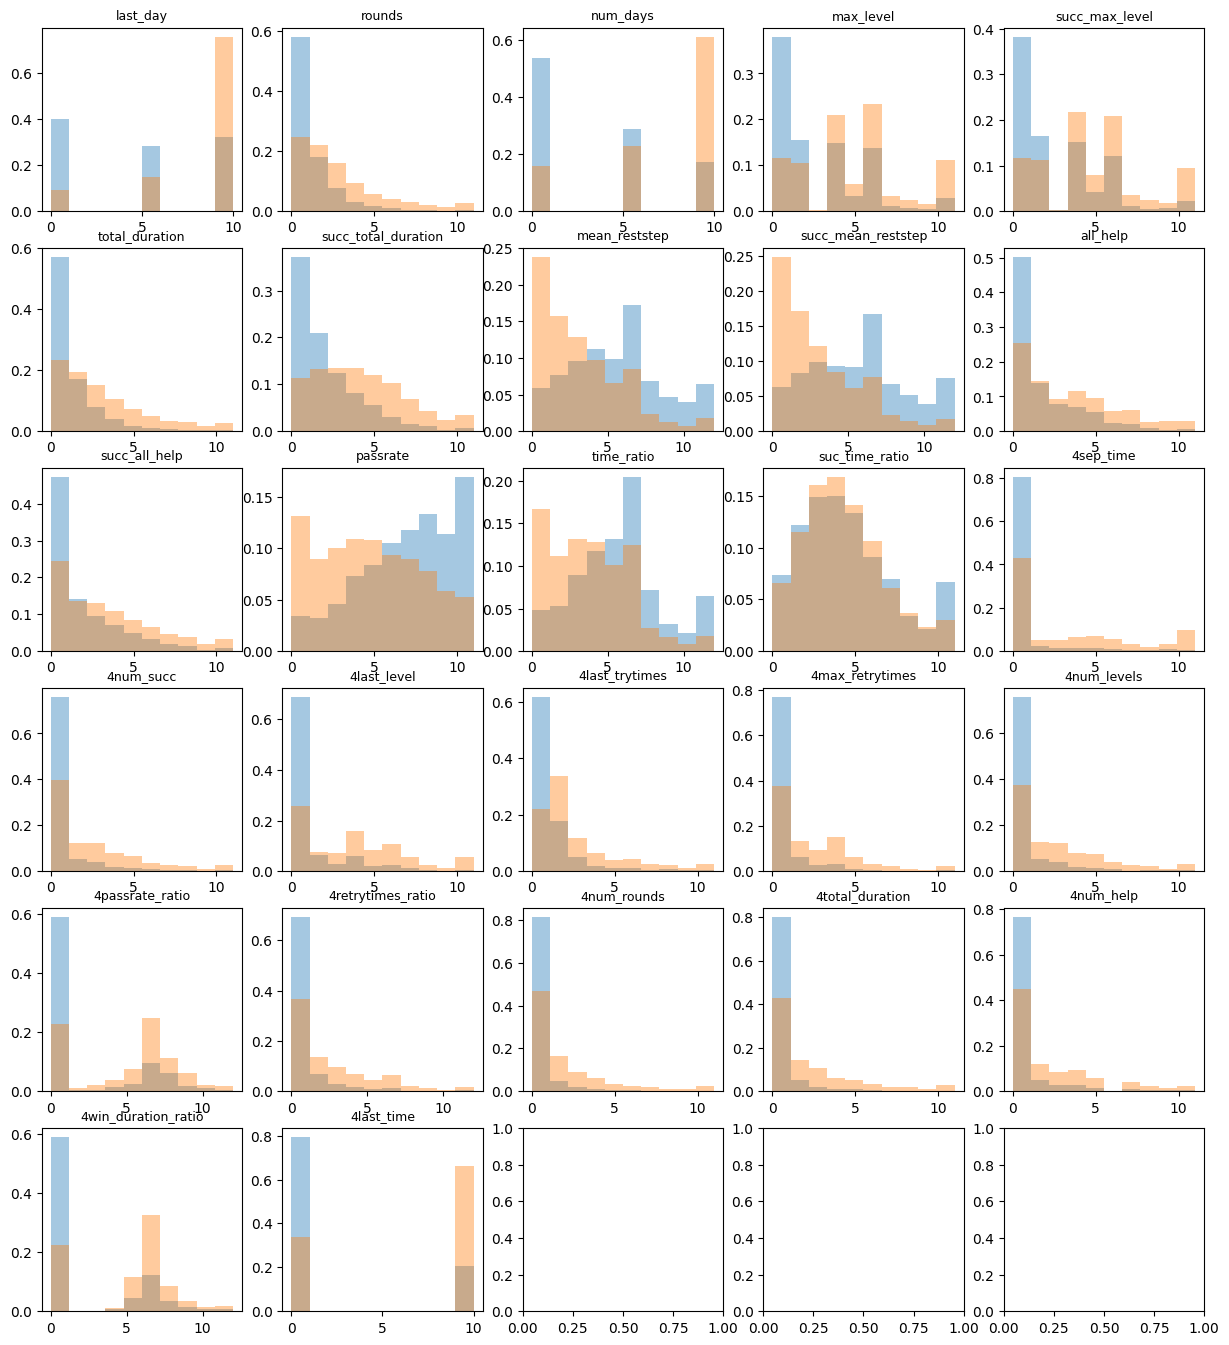

In [17]:
figure, axes = plt.subplots(6, 5, figsize = (15, 17), dpi = 100)
ax = axes.flatten()

for i, c in enumerate(discrete_train_df.columns[fea_index]):
 ax[i].hist(discrete_train_df.loc[train_df['label'] == 1][c],  alpha = 0.4,  cumulative = False, density=True)
 ax[i].hist(discrete_train_df.loc[train_df['label'] == 0][c],  alpha = 0.4,  cumulative = False, density=True)
 ax[i].set_title(c, fontsize = 9)

#plt.savefig("beforeDiscrete.png") #保存作的图
plt.show()

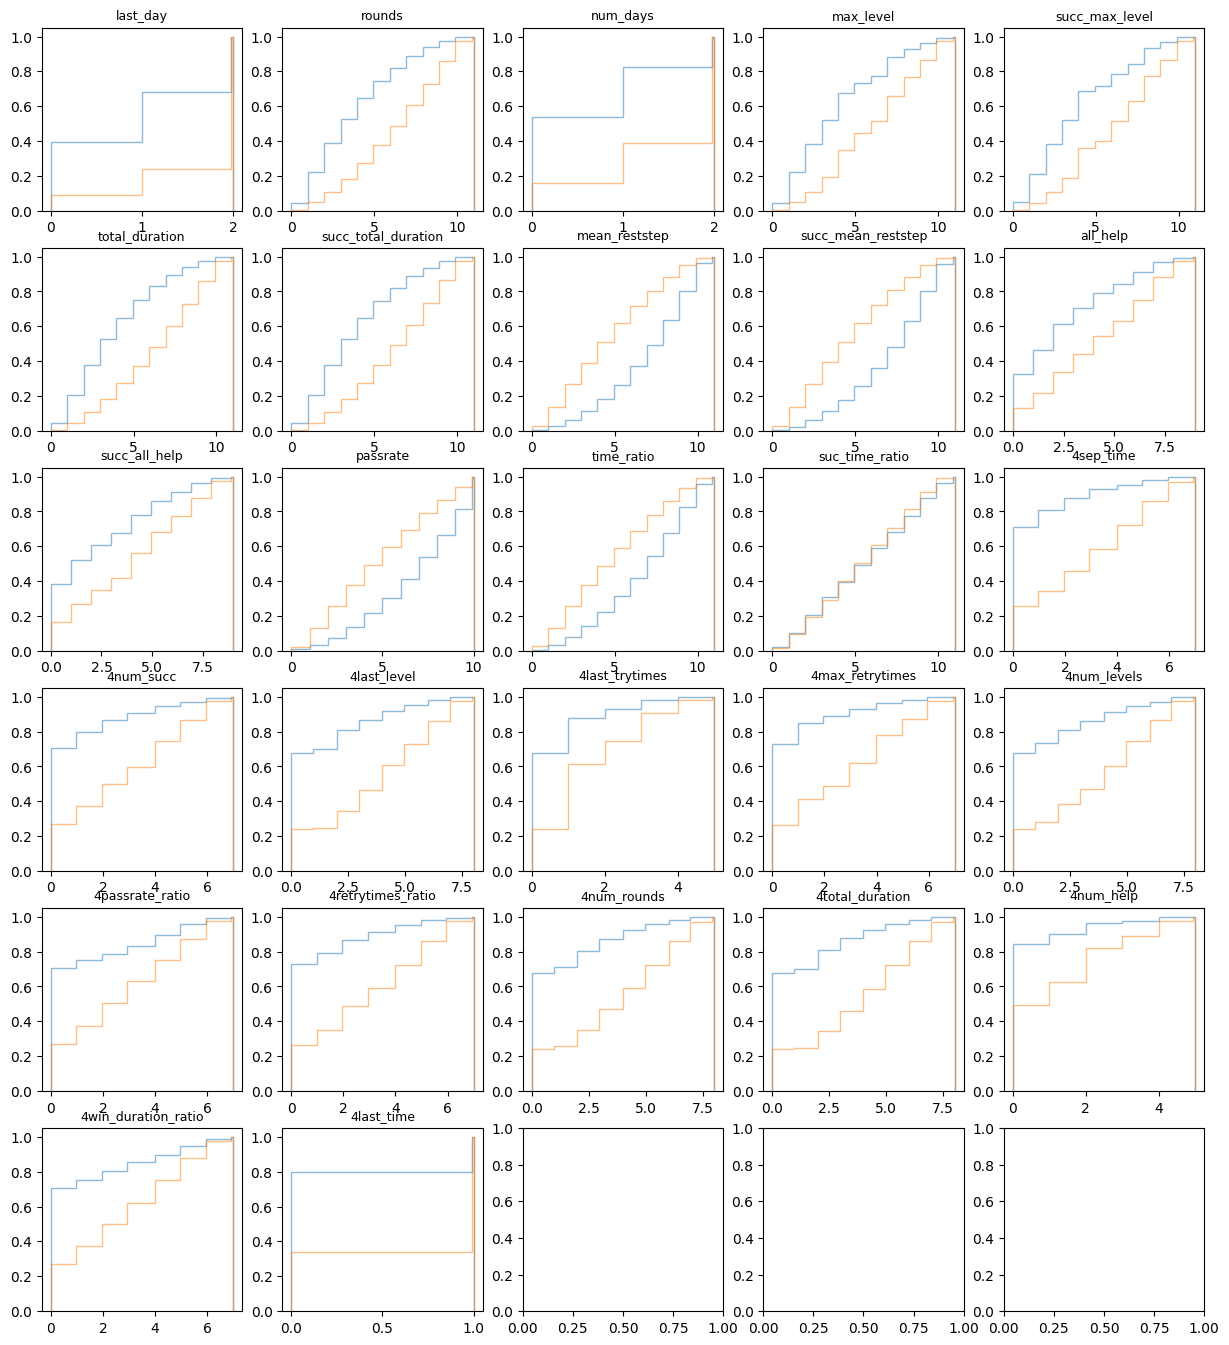

In [18]:
#等比划分
discrete_train_df, bins1, bins2 = discretedf(train_feature_df, 10, 2)
discrete_train_df
figure, axes = plt.subplots(6, 5, figsize = (15, 17), dpi = 100)
ax = axes.flatten()

for i, c in enumerate(discrete_train_df.columns[fea_index]):
 ax[i].hist(discrete_train_df.loc[train_df['label'] == 1][c], bins = 100, alpha = 0.5, histtype='step', cumulative = True, density=True)
 ax[i].hist(discrete_train_df.loc[train_df['label'] == 0][c], bins = 100, alpha = 0.5, histtype='step', cumulative = True, density=True)
 ax[i].set_title(c, fontsize = 9)

#plt.savefig("beforeDiscrete.png") #保存作的图
plt.show()

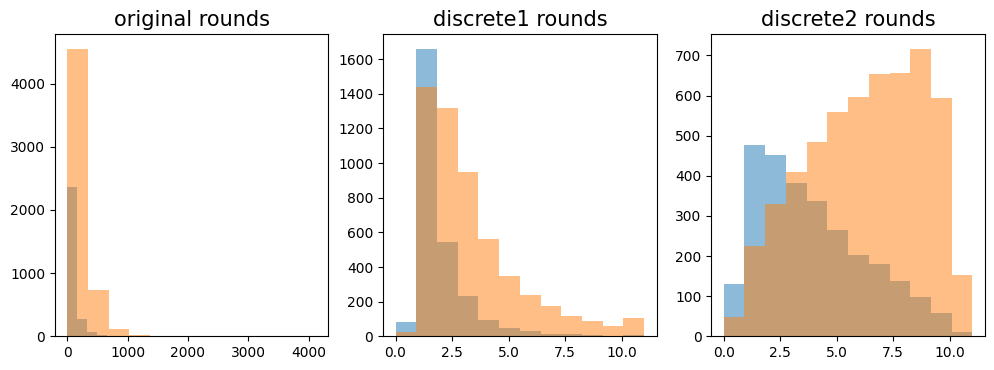

In [19]:
#对比效果
discrete_train_df1 = applydiscretedf(train_feature_df, bins1)
discrete_train_df2 = applydiscretedf(train_feature_df, bins2 )

figure, axes = plt.subplots(1, 3, figsize = (12, 4), dpi = 100)
ax = axes.flatten()

c = 'rounds'

ax[0].hist(train_feature_df.loc[train_df['label'] == 1][c], bins = 12, alpha = 0.5,  cumulative = False, density=False)
ax[0].hist(train_feature_df.loc[train_df['label'] == 0][c], bins = 12, alpha = 0.5,  cumulative = False, density=False)
ax[0].set_title('original rounds', fontsize = 15)

ax[1].hist(discrete_train_df1.loc[train_df['label'] == 1][c], bins = 12, alpha = 0.5,  cumulative = False, density=False)
ax[1].hist(discrete_train_df1.loc[train_df['label'] == 0][c], bins = 12, alpha = 0.5,  cumulative = False, density=False)
ax[1].set_title('discrete1 rounds', fontsize = 15)

ax[2].hist(discrete_train_df2.loc[train_df['label'] == 1][c], bins = 12, alpha = 0.5,  cumulative = False, density=False)
ax[2].hist(discrete_train_df2.loc[train_df['label'] == 0][c], bins = 12, alpha = 0.5,  cumulative = False, density=False)
ax[2].set_title('discrete2 rounds', fontsize = 15)

#plt.savefig("beforeDiscrete.png") #保存作的图
plt.show()

In [20]:
feature_names = train_feature_df.columns[3:]
print(feature_names)

Index(['last_day', 'rounds', 'num_days', 'max_level', 'succ_max_level',
       'total_duration', 'succ_total_duration', 'mean_reststep',
       'succ_mean_reststep', 'all_help', 'succ_all_help', 'passrate',
       'time_ratio', 'suc_time_ratio', '1sep_time', '1num_succ', '1last_level',
       '1last_trytimes', '1max_retrytimes', '1num_levels', '1passrate_ratio',
       '1retrytimes_ratio', '1num_rounds', '1total_duration', '1num_help',
       '1win_duration_ratio', '2sep_time', '2num_succ', '2last_level',
       '2last_trytimes', '2max_retrytimes', '2num_levels', '2passrate_ratio',
       '2retrytimes_ratio', '2num_rounds', '2total_duration', '2num_help',
       '2win_duration_ratio', '2last_time', '3sep_time', '3num_succ',
       '3last_level', '3last_trytimes', '3max_retrytimes', '3num_levels',
       '3passrate_ratio', '3retrytimes_ratio', '3num_rounds',
       '3total_duration', '3num_help', '3win_duration_ratio', '3last_time',
       '4sep_time', '4num_succ', '4last_level', '4last

# 一些简单的模型

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [22]:
#将训练集和验证集的特征提取出来，放到矩阵里
x_train_0 = train_feature_df[feature_names].values
x_train_0_ = scaler.fit_transform(x_train_0)
x_dev_0 = dev_feature_df[feature_names].values
x_dev_0_ = scaler.transform(x_dev_0)
x_test_0 = test_feature_df[feature_names].values
x_test_0_ = scaler.transform(x_test_0)

x_train_1 = discrete_train_df1[feature_names].values #等区间离散化的特征
x_train_1 = scaler.fit_transform(x_train_1)
discrete_dev_df1 = applydiscretedf(dev_feature_df, bins1)
x_dev_1 = discrete_dev_df1[feature_names].values
x_dev_1 = scaler.transform(x_dev_1)
discrete_test_df1 = applydiscretedf(test_feature_df, bins1)
x_test_1 = discrete_test_df1[feature_names].values
x_test_1 = scaler.transform(x_test_1)

x_train_2 = discrete_train_df2[feature_names].values #等比离散化的特征
x_train_2 = scaler.fit_transform(x_train_2)
discrete_dev_df2 = applydiscretedf(dev_feature_df, bins2)
x_dev_2 = discrete_dev_df2[feature_names].values
x_dev_2 = scaler.transform(x_dev_2)
discrete_test_df2 = applydiscretedf(test_feature_df, bins2)
x_test_2 = discrete_test_df2[feature_names].values
x_test_2 = scaler.transform(x_test_2)


y_train = train_feature_df['label'].values
y_dev = dev_feature_df['label'].values

## 决策树

In [29]:
#决策树
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV  # Perforing grid search
from sklearn.metrics import roc_auc_score

model = DecisionTreeClassifier(max_depth = 3)

parameters = {
              'max_depth': [1, 2, 3, 4, 5, 7, 10, 15, 20]}

gsearch = GridSearchCV(model, param_grid=parameters, scoring='roc_auc', cv=3)
gsearch.fit(x_train_1, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.788
Best parameters set:
	max_depth: 4


In [30]:
model = DecisionTreeClassifier(max_depth = 4)
model.fit(x_train_1, y_train)
proba = model.predict_proba(x_dev_1)[:,1]
roc_auc_score(y_dev, proba)

0.7910163689620778

In [31]:
model = DecisionTreeClassifier(max_depth = 3)

parameters = {
              'max_depth': [1, 2, 3, 4, 5, 7, 10, 15, 20]}

gsearch = GridSearchCV(model, param_grid=parameters, scoring='roc_auc', cv=3)
gsearch.fit(x_train_2, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.793
Best parameters set:
	max_depth: 4


In [32]:
model = DecisionTreeClassifier(max_depth = 4)
model.fit(x_train_2, y_train)
proba = model.predict_proba(x_dev_2)[:,1]
roc_auc_score(y_dev, proba)

0.7871586430558091

In [41]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth = 3)

parameters = {
              'max_depth': [1, 2, 3, 4, 5, 7, 10, 15, 20]}

gsearch = GridSearchCV(model, param_grid=parameters, scoring='roc_auc', cv=3)
gsearch.fit(x_train_1, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.789
Best parameters set:
	max_depth: 4


In [42]:
model = DecisionTreeRegressor(max_depth = 4)
model.fit(x_train_1, y_train)
proba = model.predict(x_dev_1)
roc_auc_score(y_dev, proba)

0.7910163689620778

In [43]:
model = DecisionTreeRegressor(max_depth = 3)

parameters = {
              'max_depth': [1, 2, 3, 4, 5, 7, 10, 15, 20]}

gsearch = GridSearchCV(model, param_grid=parameters, scoring='roc_auc', cv=3)
gsearch.fit(x_train_2, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.789
Best parameters set:
	max_depth: 4


In [44]:
model = DecisionTreeRegressor(max_depth = 4)
model.fit(x_train_2, y_train)
proba = model.predict(x_dev_2)
roc_auc_score(y_dev, proba)

0.7871586430558091

In [45]:
model = DecisionTreeRegressor(max_depth = 4)
model.fit(x_train_2, y_train)
proba = model.predict(x_dev_2)
roc_auc_score(y_dev, proba)

0.7871586430558091

In [46]:
model = DecisionTreeRegressor(max_depth = 3)

parameters = {
              'max_depth': [1, 2, 3, 4, 5, 7, 10, 15, 20]}

gsearch = GridSearchCV(model, param_grid=parameters, scoring='roc_auc', cv=3)
gsearch.fit(x_train_0, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.787
Best parameters set:
	max_depth: 3


In [47]:
model = DecisionTreeRegressor(max_depth = 4)
model.fit(x_train_0, y_train)
proba = model.predict(x_dev_0)
roc_auc_score(y_dev, proba)

0.7899826095964958

In [48]:
model = DecisionTreeClassifier(max_depth = 4)
model.fit(x_train_0, y_train)
proba = model.predict(x_dev_0)
roc_auc_score(y_dev, proba)

0.7224477703582374

所以说离散仅对DecisionTreeClassifier有用？

## 贝叶斯分类器

In [49]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
model.fit(x_train_0, y_train)
proba = model.predict(x_dev_0)
roc_auc_score(y_dev, proba)

0.7265190072119955

In [50]:
model = BernoulliNB()
model.fit(x_train_1, y_train)
proba = model.predict(x_dev_1)
roc_auc_score(y_dev, proba)

0.726447626333101

In [51]:
model = BernoulliNB()
model.fit(x_train_2, y_train)
proba = model.predict(x_dev_2)
roc_auc_score(y_dev, proba)

0.7295211101053216

In [52]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(x_train_0, y_train)
proba = model.predict(x_dev_0)
roc_auc_score(y_dev, proba)

0.6893538893419504

In [53]:
model = MultinomialNB()
model.fit(x_train_1, y_train)
proba = model.predict(x_dev_1)
roc_auc_score(y_dev, proba)

0.7277135314773884

In [54]:
model = MultinomialNB()
model.fit(x_train_2, y_train)
proba = model.predict(x_dev_2)
roc_auc_score(y_dev, proba)

0.7271870185343927

In [55]:
# 特征离散化对MultinomialNB有用诶，这是为什么呢？

In [56]:
from sklearn.naive_bayes import ComplementNB
model = ComplementNB()
model.fit(x_train_0, y_train)
proba = model.predict(x_dev_0)
roc_auc_score(y_dev, proba)

0.6893538893419504

In [57]:
model = ComplementNB()
model.fit(x_train_1, y_train)
proba = model.predict(x_dev_1)
roc_auc_score(y_dev, proba)

0.738072918410392

In [58]:
model = ComplementNB()
model.fit(x_train_2, y_train)
proba = model.predict(x_dev_2)
roc_auc_score(y_dev, proba)

0.7323100178957549

## SVM

In [59]:
from sklearn.svm import LinearSVR
model = LinearSVR()
model.fit(x_train_0, y_train)
proba = model.predict(x_dev_0)
roc_auc_score(y_dev, proba)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5908694380556101

In [62]:
model = LinearSVR()
model.fit(x_train_0_, y_train)
proba = model.predict(x_dev_0_)
roc_auc_score(y_dev, proba)

0.7087805429621297

In [60]:
model = LinearSVR()
model.fit(x_train_1, y_train)
proba = model.predict(x_dev_1)
roc_auc_score(y_dev, proba)

0.7270155149182879

In [61]:
model = LinearSVR()
model.fit(x_train_2, y_train)
proba = model.predict(x_dev_2)
roc_auc_score(y_dev, proba)

0.7240813186132906

## MLP

In [63]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300).fit(x_train_0, y_train)
proba = clf.predict_proba(x_dev_0)[:, 1]
roc_auc_score(y_dev, proba)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7453528205238347

In [66]:
clf = MLPClassifier(random_state=1, max_iter=300).fit(x_train_0_, y_train)
proba = clf.predict_proba(x_dev_0_)[:, 1]
roc_auc_score(y_dev, proba)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7869722947436512

In [64]:
clf = MLPClassifier(random_state=1, max_iter=300).fit(x_train_1, y_train)
proba = clf.predict_proba(x_dev_1)[:, 1]
roc_auc_score(y_dev, proba)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7565292974289618

In [65]:
clf = MLPClassifier(random_state=1, max_iter=300).fit(x_train_2, y_train)
proba = clf.predict_proba(x_dev_2)[:, 1]
roc_auc_score(y_dev, proba)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7500462712334426

# 集成模型

## XGBoost

In [67]:
from xgboost import XGBClassifier
model = XGBClassifier(
    # eta = 0.001,
    # max_depth = 2,
    # alpha = 0
    )
model.fit(x_train_0, y_train)
proba = model.predict_proba(x_dev_0)[:, 1]
roc_auc_score(y_dev, proba)

0.8021243075896825

In [68]:
model = XGBClassifier(
    # eta = 0.001,
    # max_depth = 2,
    # alpha = 0
    )
model.fit(x_train_1, y_train)
proba = model.predict_proba(x_dev_1)[:, 1]
roc_auc_score(y_dev, proba)

0.8008508221750701

In [69]:
model = XGBClassifier(
    # eta = 0.001,
    # max_depth = 2,
    # alpha = 0
    )
model.fit(x_train_2, y_train)
proba = model.predict_proba(x_dev_2)[:, 1]
roc_auc_score(y_dev, proba)

0.7993325571978772

## LGBM

In [70]:
import lightgbm as lgb
gbm = lgb.LGBMClassifier(boosting_type='gbdt',
                         objective = 'binary',
                         metric = 'auc',
                         verbose = 0,
                         max_depth = 3,
                         learning_rate = 0.02,
                         num_leaves = 35,
                         feature_fraction=0.6,
                         bagging_fraction= 0.7,
                         bagging_freq= 6,
                         lambda_l1= 0,
                         lambda_l2= 10,
                         cat_smooth = 1,
                         class_weight = 'balanced')
gbm.fit(x_train_0, y_train)
proba = gbm.predict_proba(x_dev_0)[:, 1]
roc_auc_score(y_dev, proba)

0.8018441534322516

In [71]:
gbm = lgb.LGBMClassifier(boosting_type='gbdt',
                         objective = 'binary',
                         metric = 'auc',
                         verbose = 0,
                         max_depth = 3,
                         learning_rate = 0.02,
                         num_leaves = 35,
                         feature_fraction=0.6,
                         bagging_fraction= 0.7,
                         bagging_freq= 6,
                         lambda_l1= 0,
                         lambda_l2= 10,
                         cat_smooth = 1,
                         class_weight = 'balanced')
gbm.fit(x_train_1, y_train)
proba = gbm.predict_proba(x_dev_1)[:, 1]
roc_auc_score(y_dev, proba)

0.801112657345882

In [72]:
gbm = lgb.LGBMClassifier(boosting_type='gbdt',
                         objective = 'binary',
                         metric = 'auc',
                         verbose = 0,
                         max_depth = 3,
                         learning_rate = 0.02,
                         num_leaves = 35,
                         feature_fraction=0.6,
                         bagging_fraction= 0.7,
                         bagging_freq= 6,
                         lambda_l1= 0,
                         lambda_l2= 10,
                         cat_smooth = 1,
                         class_weight = 'balanced')
gbm.fit(x_train_2, y_train)
proba = gbm.predict_proba(x_dev_2)[:, 1]
roc_auc_score(y_dev, proba)

0.8016855994446189

In [ ]:
proba = gbm.predict_proba(x_test_2)[:, 1]
proba

array([0.18739509, 0.19659549, 0.73372628, ..., 0.20735072, 0.59451688,
       0.57690978])

## 集成模型调优

eta :  [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
eta  =  0.001 , auc =  0.7904926986204539
eta  =  0.01 , auc =  0.7980056940463924
eta  =  0.05 , auc =  0.7989162740191921
eta  =  0.1 , auc =  0.8000476293652092
eta  =  0.2 , auc =  0.795194045444984
eta  =  0.3 , auc =  0.7925298962703176
eta  =  0.5 , auc =  0.7769426495697882
eta  =  1 , auc =  0.7465997749923091


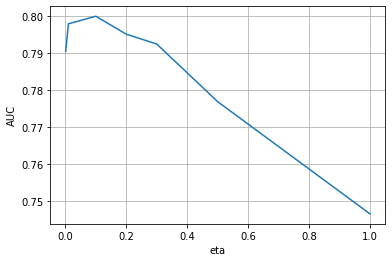

In [ ]:
# XGBClassifier调优
import matplotlib.pyplot as plt

parameters = {
    'n_estimators': [1, 2, 16, 64, 128, 256, 512, 1024, 2048],
    # 'n_estimators': [60, 65, 70, 75, 80, 85, 90],
    'max_depth': [1, 2, 3,
                  4, 5, 6, 7, 10, 15
                  ],
    'min_child_weight': [0.1, 0.5, 1, 2, 3, 4, 5, 6, 10],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 1, 2, 3, 4],
    'subsample': [0.01, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'reg_alpha': [0, 0.05, 0.1, 1, 2, 3, 10, 50, 100, 200], 
    # 'reg_alpha': [30, 40, 50,  60, 70], 
    'reg_lambda': [0.05, 0.1, 1, 2, 3],
    'eta': [0.001, 0.01, 0.05, 0.1,  0.2, 0.3, 0.5, 1],
    
}

parameter = 'eta'

aucs = []
print(parameter, ': ', parameters[parameter])
for i in parameters[parameter]:
  model = XGBClassifier(
      n_estimators = 80,
      max_depth = 3,
      min_child_weight = 1,
      gamma = 0,
      subsample = 1,
      colsample_bytree = 1,
      reg_alpha = 0,
      reg_lambda = 1 ,
      learning_rate = i,
      )
  model.fit(x_train_0, y_train)
  proba = model.predict_proba(x_dev_0)[:, 1]
  auc_i = roc_auc_score(y_dev, proba)
  aucs.append(auc_i)
  print(parameter, ' = ', i, ', auc = ', auc_i)



plt.plot(parameters[parameter], aucs)
plt.xlabel(parameter)
plt.ylabel('AUC')
plt.grid()
plt.show()

auc:  0.8032016535096336


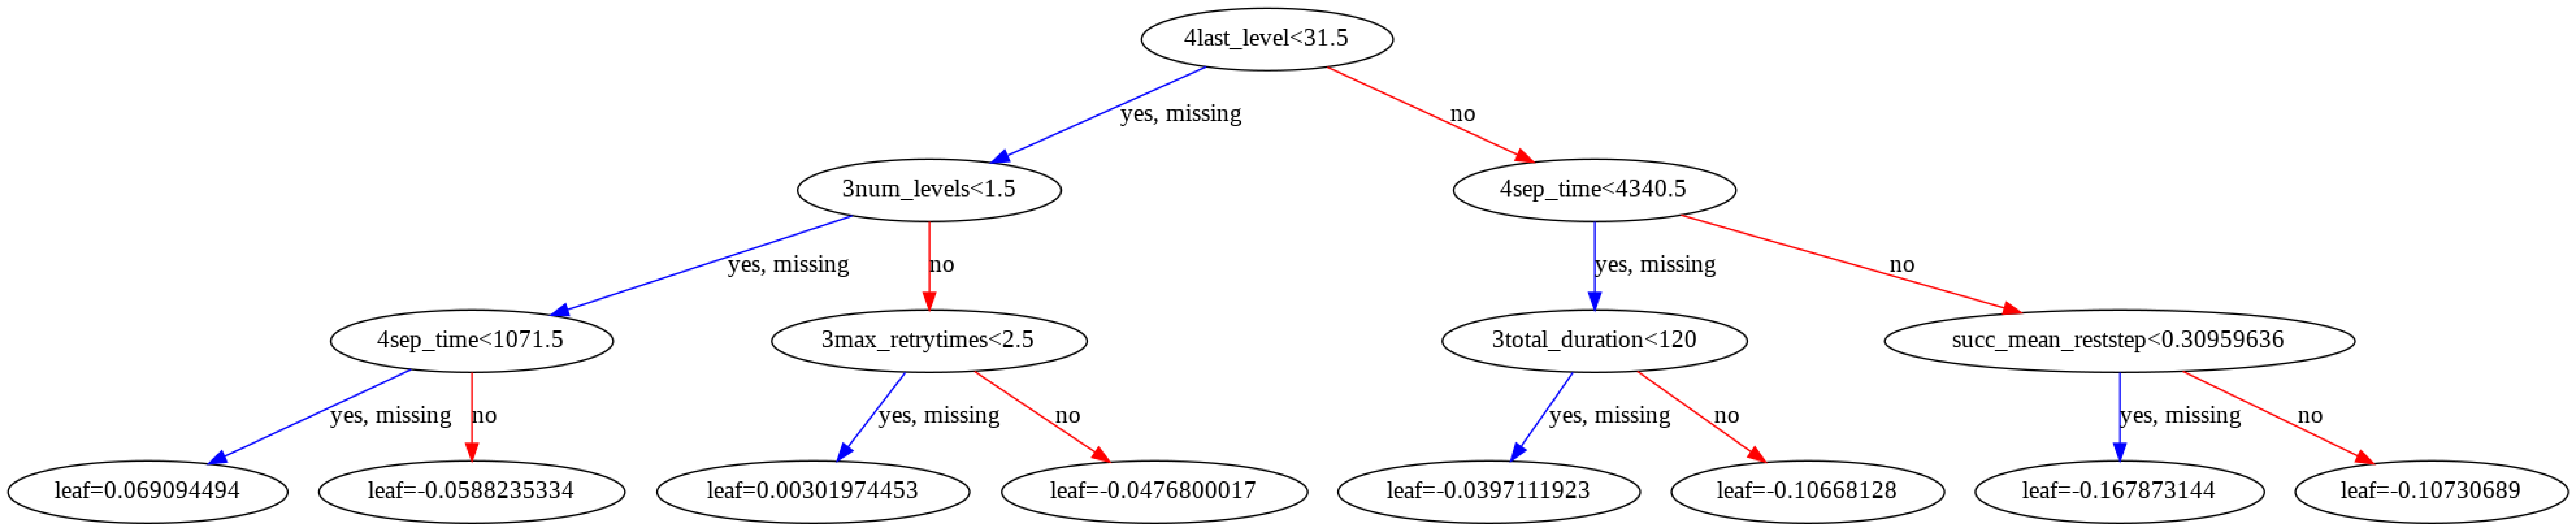

In [73]:
import xgboost as xgb

model = XGBClassifier(
      n_estimators = 80,
      max_depth = 3,
      min_child_weight = 1,
      gamma = 0,
      subsample = 1,
      colsample_bytree = 1,
      reg_alpha = 0,
      reg_lambda = 1 ,
      learning_rate = 0.1,
      )
model.fit(x_train_0, y_train)
proba = model.predict_proba(x_dev_0)[:, 1]
auc = roc_auc_score(y_dev, proba)

print("auc: ", auc)


def create_feature_map(features):
    outfile = open('clf.fmap','w')
    for i,f in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i,f))
    outfile.close()
create_feature_map(train_feature_df.columns[3:])


xgb.plot_tree(model, num_trees=0, fmap='clf.fmap')
fig = plt.gcf()
fig.set_size_inches((240, 240))
# fig.savefig('tree.png')

In [74]:
model = XGBClassifier(
      n_estimators = 80,
      max_depth = 3,
      min_child_weight = 1,
      gamma = 0,
      subsample = 1,
      colsample_bytree = 1,
      reg_alpha = 0,
      reg_lambda = 1 ,
      learning_rate = 0.1,
      )
model.fit(x_train_1, y_train)
proba = model.predict_proba(x_dev_1)[:, 1]
auc = roc_auc_score(y_dev, proba)

print("auc: ", auc)


auc:  0.801641381201056


In [75]:
model = XGBClassifier(
      n_estimators = 80,
      max_depth = 3,
      min_child_weight = 1,
      gamma = 0,
      subsample = 1,
      colsample_bytree = 1,
      reg_alpha = 0,
      reg_lambda = 1 ,
      learning_rate = 0.1,
      )
model.fit(x_train_2, y_train)
proba = model.predict_proba(x_dev_2)[:, 1]
auc = roc_auc_score(y_dev, proba)

print("auc: ", auc)

auc:  0.7997899001741566


In [78]:
model = XGBClassifier(
      n_estimators = 80,
      max_depth = 3,
      min_child_weight = 1,
      gamma = 0,
      subsample = 1,
      colsample_bytree = 1,
      reg_alpha = 0,
      reg_lambda = 1 ,
      learning_rate = 0.1,
      )
model.fit(x_train_0_, y_train)
proba = model.predict_proba(x_dev_0_)[:, 1]
auc = roc_auc_score(y_dev, proba)

print("auc: ", auc)


auc:  0.8031978633744711


In [77]:
model = XGBClassifier(
      n_estimators = 80,
      max_depth = 3,
      min_child_weight = 1,
      gamma = 0,
      subsample = 1,
      colsample_bytree = 1,
      reg_alpha = 0,
      reg_lambda = 1 ,
      learning_rate = 0.1,
      )
model.fit(x_train_0, y_train)
proba = model.predict_proba(x_dev_0)[:, 1]
auc = roc_auc_score(y_dev, proba)

print("auc: ", auc)
proba = model.predict_proba(x_test_0)[:, 1]

auc:  0.8032016535096336


learning_rate :  [0.001, 0.01, 0.015, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2]
learning_rate  =  0.001 , auc =  0.8001411193658851
learning_rate  =  0.01 , auc =  0.8012070948803485
learning_rate  =  0.015 , auc =  0.8008230278505448
learning_rate  =  0.02 , auc =  0.8010655965009472
learning_rate  =  0.03 , auc =  0.8005062357198762
learning_rate  =  0.05 , auc =  0.8003160972725556
learning_rate  =  0.1 , auc =  0.7975631957661663
learning_rate  =  0.15 , auc =  0.7908982430828454
learning_rate  =  0.2 , auc =  0.7894017713828372


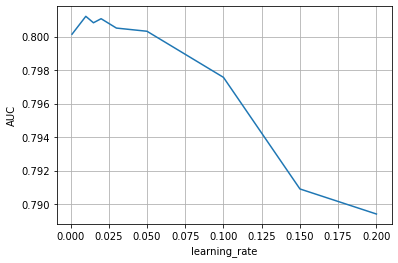

In [79]:
parameters = {
              'max_depth': [1, 2, 3, 4, 5, 6, 7,  9, 10, 15, 20, 40],          
              'feature_fraction': [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1],
              'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
              'bagging_freq': [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
              'lambda_l1': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
              'lambda_l2': [0, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30],
              'cat_smooth': [1, 10, 15, 20, 35],
              'learning_rate': [0.001, 0.01, 0.015, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2],
}

parameter = 'learning_rate'

aucs = []
print(parameter, ': ', parameters[parameter])
for i in parameters[parameter]:
  model = lgb.LGBMClassifier(boosting_type='gbdt',
                          objective = 'binary',
                          metric = 'auc',
                          verbose = 0,
                          max_depth = 4,
                          learning_rate = i,
                          num_leaves = 35,
                          feature_fraction=0.5,
                          bagging_fraction= 0.7,
                          bagging_freq= 10,
                          lambda_l1= 0.4,
                          lambda_l2= 10,
                          cat_smooth = 10)


  model.fit(x_train_0, y_train)
  proba = model.predict_proba(x_dev_0)[:, 1]
  auc_i = roc_auc_score(y_dev, proba)
  aucs.append(auc_i)
  print(parameter, ' = ', i, ', auc = ', auc_i)



plt.plot(parameters[parameter], aucs)
plt.xlabel(parameter)
plt.ylabel('AUC')
plt.grid()
plt.show()

In [80]:
model = lgb.LGBMClassifier(boosting_type='gbdt',
                          objective = 'binary',
                          metric = 'auc',
                          verbose = 0,
                          max_depth = 4,
                          learning_rate = 0.02,
                          num_leaves = 35,
                          feature_fraction=0.5,
                          bagging_fraction= 0.7,
                          bagging_freq= 10,
                          lambda_l1= 0.4,
                          lambda_l2= 10,
                          cat_smooth = 10)


model.fit(x_train_0, y_train)
proba = model.predict_proba(x_dev_0)[:, 1]
auc_i = roc_auc_score(y_dev, proba)
aucs.append(auc_i)
print('auc = ', auc_i)

auc =  0.8010655965009472


In [81]:
model.fit(x_train_0, y_train)
proba = model.predict_proba(x_dev_0)[:, 1]
auc_i = roc_auc_score(y_dev, proba)
aucs.append(auc_i)
print('auc = ', auc_i)

auc =  0.8010655965009472


In [82]:
model.fit(x_train_1, y_train)
proba = model.predict_proba(x_dev_1)[:, 1]
auc_i = roc_auc_score(y_dev, proba)
aucs.append(auc_i)
print('auc = ', auc_i)

auc =  0.8009247298107396


In [83]:
model.fit(x_train_2, y_train)
proba = model.predict_proba(x_dev_2)[:, 1]
auc_i = roc_auc_score(y_dev, proba)
aucs.append(auc_i)
print('auc = ', auc_i)

auc =  0.800724800180916


In [84]:
model.fit(x_train_0, y_train)
proba = model.predict_proba(x_dev_0)[:, 1]
auc_i = roc_auc_score(y_dev, proba)
aucs.append(auc_i)
print('auc = ', auc_i)
proba = model.predict_proba(x_test_0)[:, 1]

auc =  0.8010655965009472


In [90]:
output=pd.DataFrame({'user_id':test_df.user_id,'proba':proba})
output.to_csv('/content/drive/MyDrive/Colab Notebooks/xtzx/proj/result.csv', index=None) 

# 特征分析

In [23]:
from xgboost import XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

model = XGBClassifier(
      n_estimators = 80,
      max_depth = 3,
      min_child_weight = 1,
      gamma = 0,
      subsample = 1,
      colsample_bytree = 1,
      reg_alpha = 0,
      reg_lambda = 1 ,
      learning_rate = 0.1,
      )
model.fit(x_train_0, y_train)
proba = model.predict_proba(x_dev_0)[:, 1]
auc = roc_auc_score(y_dev, proba)
proba = model.predict_proba(x_test_0)[:, 1]
print(auc)

0.8032016535096336


In [24]:
feature_names

Index(['last_day', 'rounds', 'num_days', 'max_level', 'succ_max_level',
       'total_duration', 'succ_total_duration', 'mean_reststep',
       'succ_mean_reststep', 'all_help', 'succ_all_help', 'passrate',
       'time_ratio', 'suc_time_ratio', '1sep_time', '1num_succ', '1last_level',
       '1last_trytimes', '1max_retrytimes', '1num_levels', '1passrate_ratio',
       '1retrytimes_ratio', '1num_rounds', '1total_duration', '1num_help',
       '1win_duration_ratio', '2sep_time', '2num_succ', '2last_level',
       '2last_trytimes', '2max_retrytimes', '2num_levels', '2passrate_ratio',
       '2retrytimes_ratio', '2num_rounds', '2total_duration', '2num_help',
       '2win_duration_ratio', '2last_time', '3sep_time', '3num_succ',
       '3last_level', '3last_trytimes', '3max_retrytimes', '3num_levels',
       '3passrate_ratio', '3retrytimes_ratio', '3num_rounds',
       '3total_duration', '3num_help', '3win_duration_ratio', '3last_time',
       '4sep_time', '4num_succ', '4last_level', '4last

In [25]:
len(feature_names)

65

In [26]:
#取出每个feature, 跑模型看效果

aucs = []

for i, feature_name in enumerate(feature_names):

  x_train_0 = train_feature_df[feature_name].values.reshape(-1,1)
  x_dev_0 = dev_feature_df[feature_name].values.reshape(-1,1)
  x_test_0 = test_feature_df[feature_name].values.reshape(-1,1)

  model = XGBClassifier(
      n_estimators = 80,
      max_depth = 3,
      min_child_weight = 1,
      gamma = 0,
      subsample = 1,
      colsample_bytree = 1,
      reg_alpha = 0,
      reg_lambda = 1 ,
      learning_rate = 0.1,
      )
  
  model.fit(x_train_0, y_train)
  proba = model.predict_proba(x_dev_0)[:, 1]
  auc = roc_auc_score(y_dev, proba)
  aucs.append(auc)
  print("feature name: ", feature_name, ", dev AUC = ", auc)


feature name:  last_day , dev AUC =  0.7264757365022232
feature name:  rounds , dev AUC =  0.7463303595511721
feature name:  num_days , dev AUC =  0.7548420555924392
feature name:  max_level , dev AUC =  0.7233422422565959
feature name:  succ_max_level , dev AUC =  0.7229392245509795
feature name:  total_duration , dev AUC =  0.7463815263758664
feature name:  succ_total_duration , dev AUC =  0.7414543506645686
feature name:  mean_reststep , dev AUC =  0.728292158778869
feature name:  succ_mean_reststep , dev AUC =  0.7277564863425638
feature name:  all_help , dev AUC =  0.6790693575784069
feature name:  succ_all_help , dev AUC =  0.6741289163940399
feature name:  passrate , dev AUC =  0.6984846407930985
feature name:  time_ratio , dev AUC =  0.6923790488908486
feature name:  suc_time_ratio , dev AUC =  0.5290406473045506
feature name:  1sep_time , dev AUC =  0.5719519259255984
feature name:  1num_succ , dev AUC =  0.6145002991048332
feature name:  1last_level , dev AUC =  0.62094668732

Text(0.5, 1.0, 'Day4 Features')

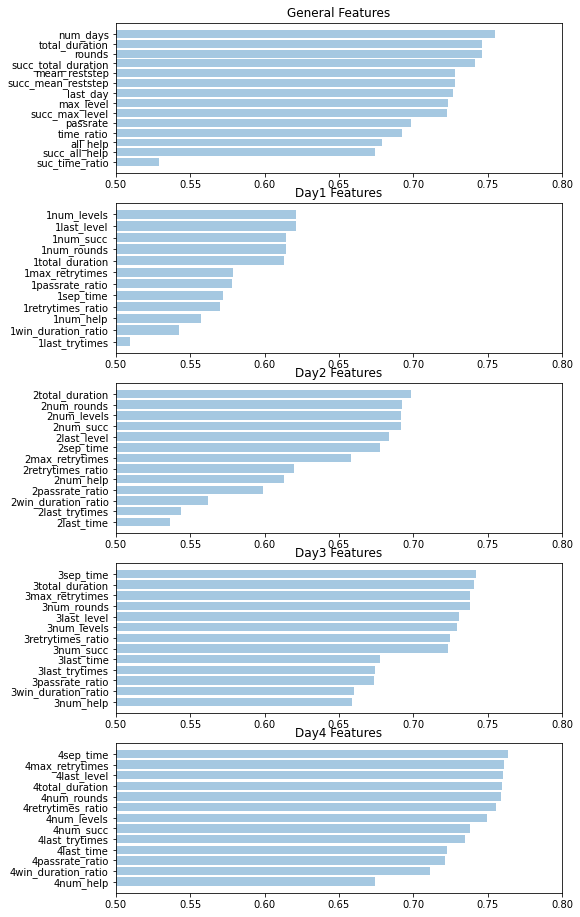

In [27]:
aucs = np.array(aucs)
index0 = (aucs[:14]).argsort()
index1 = (aucs[14:26]).argsort() + 14
index2 = (aucs[26:39]).argsort() + 26
index3 = (aucs[39:52]).argsort() + 39
index4 = (aucs[52:65]).argsort() + 52
index = [index0, index1, index2, index3, index4]
# index = range(65)
fig,axes=plt.subplots(5,1,figsize=(8, 16))
ax=axes.flatten()
for j, index_ in enumerate(index): 
  ax[j].barh(feature_names[index_], aucs[index_], alpha = 0.4)
  ax[j].set_xlim(0.5, 0.8)
  # ax[j].set_xlabel('AUC')

ax[0].set_title('General Features')
ax[1].set_title('Day1 Features')
ax[2].set_title('Day2 Features')
ax[3].set_title('Day3 Features')
ax[4].set_title('Day4 Features')
  # for i in range(len(index_)):
  #     ax[j].annotate(feature_names[index_][i], xy = (i, aucs[index_][i]), xytext = (i+0.02, aucs[index_][i])) 



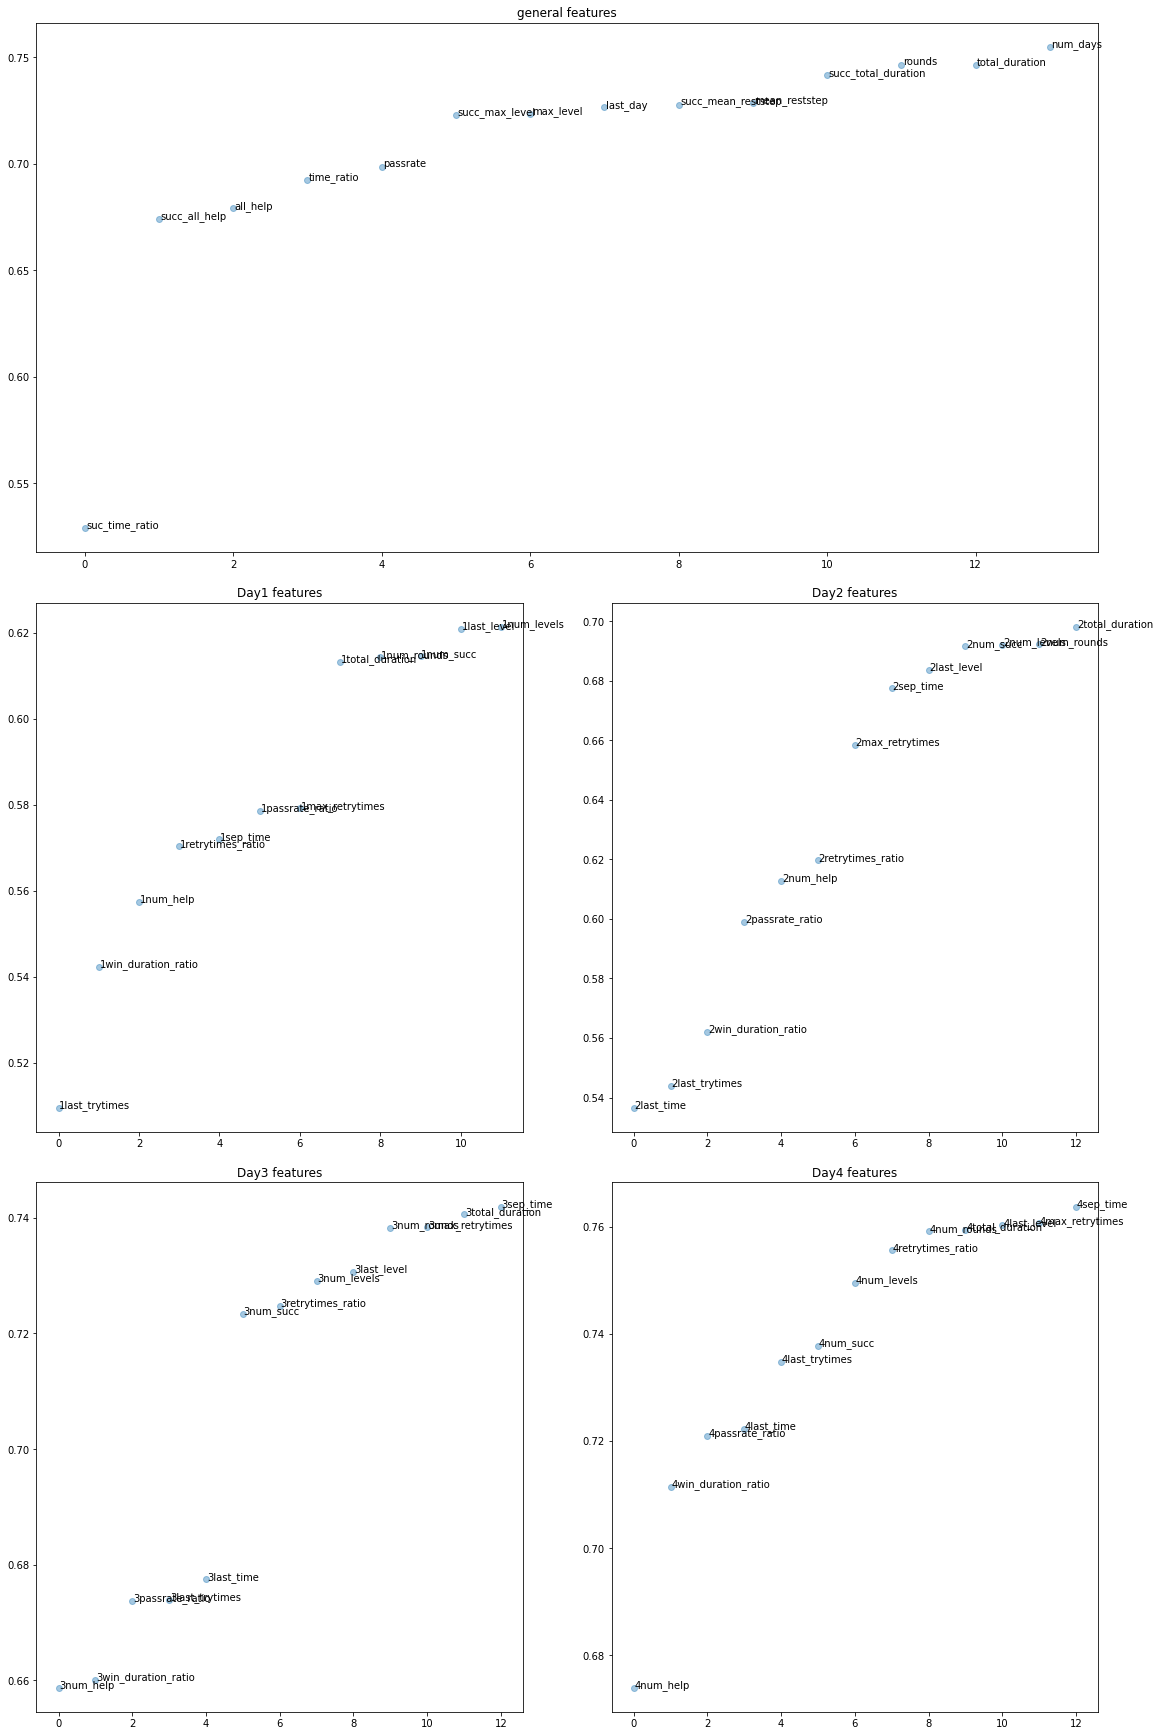

In [28]:

fig3 = plt.figure(constrained_layout=True, figsize=(16, 24))
gs = fig3.add_gridspec(3, 2)
f3_ax1 = fig3.add_subplot(gs[0, :])
f3_ax1.set_title('general features')
f3_ax2 = fig3.add_subplot(gs[1, 0])
f3_ax2.set_title('Day1 features')
f3_ax3 = fig3.add_subplot(gs[1, 1])
f3_ax3.set_title('Day2 features')
f3_ax4 = fig3.add_subplot(gs[2, 0])
f3_ax4.set_title('Day3 features')
f3_ax5 = fig3.add_subplot(gs[2, 1])
f3_ax5.set_title('Day4 features')

ax = [f3_ax1, f3_ax2, f3_ax3, f3_ax4, f3_ax5]

for j, index_ in enumerate(index): 
  ax[j].scatter(range(len(index_)), aucs[index_], marker = 'o', alpha = 0.4)
  for i in range(len(index_)):
      ax[j].annotate(feature_names[index_][i], xy = (i, aucs[index_][i]), xytext = (i+0.02, aucs[index_][i])) 
plt.show()

In [32]:
index = (-aucs).argsort()
for i in range(65):
  print(i+1, "\t", feature_names[index][i], '\t\t', aucs[index][i])

1 	 4sep_time 		 0.7637393978864944
2 	 4max_retrytimes 		 0.760629276141036
3 	 4last_level 		 0.7602489992463947
4 	 4total_duration 		 0.7594489648825027
5 	 4num_rounds 		 0.7590857435960929
6 	 4retrytimes_ratio 		 0.7555681823206619
7 	 num_days 		 0.7548420555924392
8 	 4num_levels 		 0.7494992283916498
9 	 total_duration 		 0.7463815263758664
10 	 rounds 		 0.7463303595511721
11 	 3sep_time 		 0.7419543326614266
12 	 succ_total_duration 		 0.7414543506645686
13 	 3total_duration 		 0.7406044128543696
14 	 3max_retrytimes 		 0.7383470715204823
15 	 3num_rounds 		 0.7382248396614904
16 	 4num_succ 		 0.7377753928001329
17 	 4last_trytimes 		 0.7347878187582632
18 	 3last_level 		 0.730716581904505
19 	 3num_levels 		 0.7291029318590551
20 	 mean_reststep 		 0.728292158778869
21 	 succ_mean_reststep 		 0.7277564863425638
22 	 last_day 		 0.7264757365022232
23 	 3retrytimes_ratio 		 0.7247711232128723
24 	 3num_succ 		 0.7233934090812901
25 	 max_level 		 0.7233422422565959
26 	 su

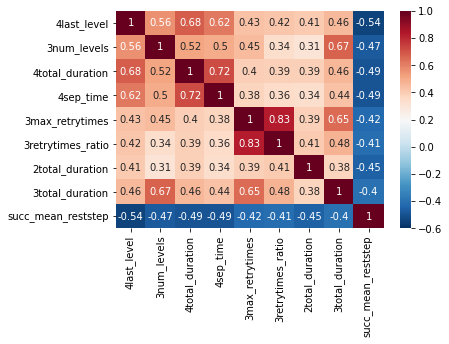

In [45]:
import seaborn as sns
features = ['4last_level', '3num_levels', '4total_duration', '4sep_time', '3max_retrytimes',
            '3retrytimes_ratio', '2total_duration', '3total_duration', 'succ_mean_reststep']

sns.heatmap(train_feature_df.loc[:, features].corr(),annot=True,cmap= "RdBu_r", vmin = -0.6)
g=plt.gcf()
# g.savefig('特征heatmap.png',dpi=300)

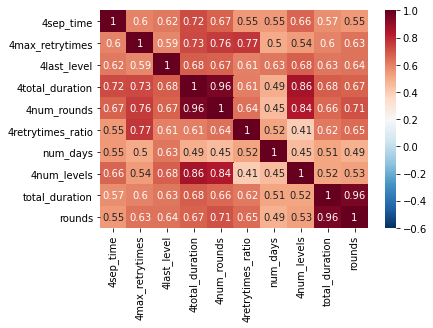

In [47]:
features = feature_names[index][:10]
sns.heatmap(train_feature_df.loc[:, features].corr(),annot=True,cmap= "RdBu_r", vmin = -0.6)
g=plt.gcf()
